In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/cyy/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using UMAP to map the features to a low dimensional space
1. loading data from MNIST dataset
2. choosing 600 data points from each training dataset (6000 in total)
3. choosing data points in propotion in the testing sets as well

In [2]:
# import umap.umap_ as umap
# from sklearn.datasets import fetch_openml
# import seaborn as sns
# from tensorflow import keras

2022-05-26 08:56:33.203792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 08:56:33.204191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# (x_tr, y_tr), (x_ts, y_ts) = keras.datasets.mnist.load_data()
# print(f'Train size: {len(y_tr)} \nTest size: {len(y_ts)}')

Train size: 60000 
Test size: 10000


In [4]:
# # train
# x_tr = x_tr[0:6000]
# x_tr = x_tr.reshape(-1, 784)
# reducer_tr = umap.UMAP(random_state = 42)
# embedding_tr = reducer_tr.fit_transform(x_tr) 

# # test
# x_ts = x_ts[0:1000]
# x_ts = x_ts.reshape(-1, 784)
# reducer_ts = umap.UMAP(random_state = 42)
# embedding_ts = reducer_ts.fit_transform(x_ts) 

# train_x, train_y, test_x, test_y = embedding_tr, y_tr[0:6000], embedding_ts, y_ts[0:1000]

In [2]:
# with open('features_UMAP.npy', 'wb') as f:
#     np.save(f, train_x)
#     np.save(f, train_y)
#     np.save(f, test_x)
#     np.save(f, test_y)


In [82]:
with open('features_UMAP.npy', 'rb') as f:
    train_x = np.load(f)
    train_y = np.load(f)
    test_x = np.load(f)
    test_y = np.load(f)
    


In [78]:
# with open('features_VAE.npy', 'rb') as f:
#     train_x = np.load(f)
#     train_y = np.load(f)
#     test_x = np.load(f)
#     test_y = np.load(f)

for binary training

In [6]:
# train_y01 = train_y[np.where(train_y <= 1)]
# train_x01 = train_x[np.where(train_y <= 1)]
# test_y01 = test_y[np.where(test_y <= 1)]
# test_x01 = test_x[np.where(test_y <= 1)]
# train_x, train_y, test_x, test_y = \
#     torch.from_numpy(train_x01), torch.from_numpy(train_y01), \
#         torch.from_numpy(test_x01), torch.from_numpy(test_y01)

using all classes

In [83]:
train_x, train_y, test_x, test_y = \
    torch.from_numpy(train_x), torch.from_numpy(train_y), \
        torch.from_numpy(test_x), torch.from_numpy(test_y)

In [7]:
train_y.shape

torch.Size([1263])

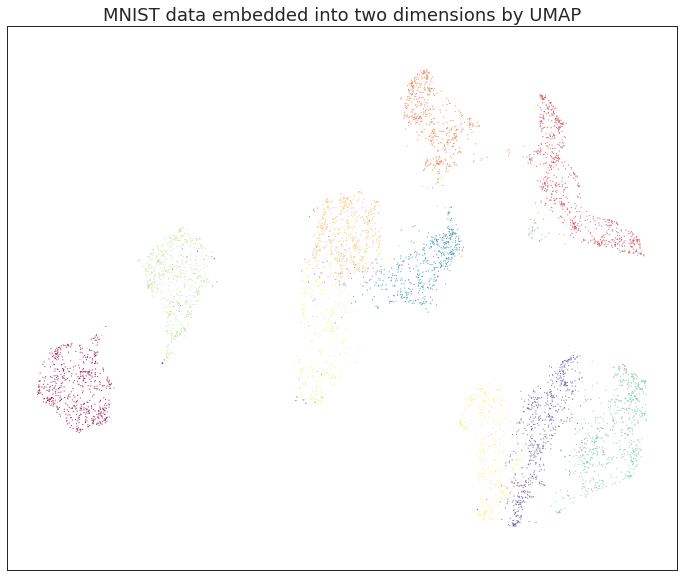

In [16]:
import seaborn as sns
sns.set(context="paper", style="white")

fig, ax = plt.subplots(figsize=(12, 10))
color = train_y.astype(int)
plt.scatter(train_x[:, 0], train_x[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.gca().set_aspect('equal', 'datalim')
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

## Setting up the Model

In [5]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [84]:
train_x, train_y = train_x[0: 1000], train_y[0: 1000]

In [85]:
train_y = train_y.to(torch.int64)
test_y = test_y.to(torch.int64)

In [86]:
train_y.shape

torch.Size([1000])

In [87]:
train_x.shape

torch.Size([1000, 2])

## One model

In [91]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
# print(train_y)
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise = True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes = likelihood.num_classes)

Train and Fit the Model

In [92]:
# import os
# smoke_test = ('CI' in os.environ)
training_iter = 10


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = lr)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [94]:
for i in range(training_iter):
    # if(i%50 == 0):
    #     lr *= 0.1
    #     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    
    # for j in range(len(train_y)//100):
        
    #     # Zero gradients from previous iteration
    #     optimizer.zero_grad()
    #     # Output from model
    #     output = model(train_x[100*j: 100*(j+1)])
    #     # Calc loss and backprop gradients
    #     loss = -mll(output, likelihood.transformed_targets[:, 100*j: 100*(j+1)]).sum()
    #     loss.backward()
        
    if i % 1 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/10 - Loss: 20.220   lengthscale: 1.247   noise: 0.364
Iter 2/10 - Loss: 20.042   lengthscale: 1.300   noise: 0.350
Iter 3/10 - Loss: 19.887   lengthscale: 1.352   noise: 0.340
Iter 4/10 - Loss: 19.769   lengthscale: 1.402   noise: 0.330
Iter 5/10 - Loss: 19.675   lengthscale: 1.449   noise: 0.323
Iter 6/10 - Loss: 19.546   lengthscale: 1.495   noise: 0.316
Iter 7/10 - Loss: 19.426   lengthscale: 1.539   noise: 0.310
Iter 8/10 - Loss: 19.395   lengthscale: 1.581   noise: 0.305
Iter 9/10 - Loss: 19.344   lengthscale: 1.620   noise: 0.300
Iter 10/10 - Loss: 19.269   lengthscale: 1.658   noise: 0.296


Evaluation

In [95]:
model.eval()
likelihood.eval()


with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc

In [96]:
pred_y = torch.argmax(pred_means, dim = 0)

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.428

## Ten models

In [93]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        # num_classes = 1
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [94]:
models, likelihoods, mlls = [], [], []
for j in range(10):
    y = train_y[train_y == j]
    x = train_x[train_y == j]
    y = torch.zeros_like(y)
    likelihood = DirichletClassificationLikelihood(y, learn_additional_noise = True)
    model = DirichletGPModel(x, likelihood.transformed_targets, likelihood, num_classes = likelihood.num_classes)
    likelihood.train()
    model.train()
    likelihoods.append(likelihood)
    models.append(model)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mlls.append(mll)

In [95]:
# import os
# smoke_test = ('CI' in os.environ)
training_iter = 100


# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# Use the adam optimizer
lr = 0.1
opts = []
for j in range(10):
    optimizer = torch.optim.Adam(models[j].parameters(), lr = lr)  # Includes GaussianLikelihood parameters
    opts.append(optimizer)

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [96]:
for j in range(10):
    print("Model", j)
    model = models[j]
    likelihood = likelihoods[j]
    mll = mlls[j]
    x = train_x[train_y == j]
    optimizer = opts[j]
    # loss = losses[j]
    for i in range(training_iter):        
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(x)
        # print(output)
        
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
          
        if i % 1 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

Model 0
Iter 1/100 - Loss: 1.159   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.135   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 1.112   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 1.090   lengthscale: 0.853   noise: 0.554
Iter 5/100 - Loss: 1.069   lengthscale: 0.911   noise: 0.513
Iter 6/100 - Loss: 1.050   lengthscale: 0.969   noise: 0.474
Iter 7/100 - Loss: 1.031   lengthscale: 1.029   noise: 0.438
Iter 8/100 - Loss: 1.013   lengthscale: 1.090   noise: 0.404
Iter 9/100 - Loss: 0.995   lengthscale: 1.152   noise: 0.372
Iter 10/100 - Loss: 0.979   lengthscale: 1.214   noise: 0.343
Iter 11/100 - Loss: 0.963   lengthscale: 1.277   noise: 0.315
Iter 12/100 - Loss: 0.947   lengthscale: 1.339   noise: 0.290
Iter 13/100 - Loss: 0.933   lengthscale: 1.400   noise: 0.267
Iter 14/100 - Loss: 0.920   lengthscale: 1.461   noise: 0.245
Iter 15/100 - Loss: 0.908   lengthscale: 1.521   noise: 0.225
Iter 16/100 - Loss: 0.896   lengthscale: 1.580   noise: 0.207
Iter 17/1

## Model Predictions

In [97]:
for model in models:
    model.eval()
for likelihood in likelihoods:
    likelihood.eval()

test_dists, preds = [], []
for j in range(10):
    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        test_dist = models[j](test_x)
        pred_means = test_dist.loc
        test_dists.append(test_dist)
        preds.append(pred_means)

In [98]:
# preds[0][0, 1], preds[1][0, 1], preds[5][0, 1], preds[6][0, 1], preds[7][0, 1], preds[8][0, 1], preds[9][0, 1]

In [99]:
pred_y = []

for i in range(len(preds[0][0])): # 
    temp = []
    for j in range(10):
        temp.append(preds[j][0, i])
    temp = np.array(temp)
    #print(temp)
    pred_y.append(np.argmax(temp))
    #print(pred_y)

In [100]:
pred_y = torch.as_tensor(pred_y)

In [101]:
pred_y[0:5]

tensor([0, 0, 0, 0, 0])

In [102]:
test_y[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [103]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.085